## ~ 30 points up and 30 pts down byt granularity of .1nv
    1.258 volts is lowest filam,emnt voltage
    highest accelerating = 57.0 v
    lowest retarfing = 0.000 V\
    
NOTE:
* we will use 2 volt meters to make sure the accelarating voltage dooesn't fluctuate by 10 volts as it seemedn to have been doing some times.

* We will only use the orange (Vsense U1233A) to wrrite down data, and the yellow one is for qualatative consistency 



10-19-18

* As temperature increases the mean free path of electrons decreases (this is iintuitce in terms of kiinetic energy vs voltage). The electrons now begin ionizing Hg resulting in positively charged Hg+ ions. These, due to the $\Delta V_{ga} = 27V$ (retarding) (anode is at lower potential), will flow towards and accumulate at the anode. As a result, electrons must flow from ground, through the keithley and onto the anode thus providing an increasing current as the retarding voltage decreases

# Oct 22nd, 2018

## Box off, bulb out
* Min Filament V: 1.253
* Min Cathode V: 0.4e-3 V
* Min Grid V: 0.0e-3 V

## Box on, bulb in
* Cathode: 5.000 V

# Oct 25, 2018

## Ionization potential of Mercury

In [1]:
# add parent direftory to path
import sys
sys.path.append("../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import (
    optimize as opt,
    signal
)
from common import chi_squared

matplotlib.rcParams['errorbar.capsize'] = 3
BOX_PROPS = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
plt.rcParams.update({'font.size': 14})

In [2]:
def linear(x, *p):
    m, b = p
    return m*x+b

array([20.17486549,  1.42634432])

0.3287441127405337

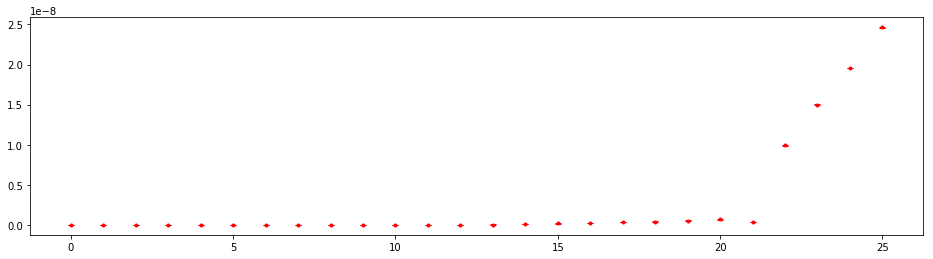

In [3]:
from itertools import product

hg_ion = np.flip(np.loadtxt("data/ion.tsv"), 0)
fig, ax = plt.subplots(figsize=(16,4))

ax.errorbar(hg_ion[:,0], hg_ion[:,1], yerr=hg_ion[:,2], fmt='r.');

nl_ops = np.arange(8,22)
nr_ops = np.array([3,4,5])
nss = list(product(nl_ops, nr_ops))

def do_da_fit(n_l, n_r, ax=None):
    # x-axis
    hg_ion_fit_x, var_matrix1 = opt.curve_fit(linear, hg_ion[0:n_l, 0], hg_ion[0:n_l, 1], p0=[1,0])

    # line
    hg_ion_fit_line, var_matrix2 = opt.curve_fit(linear, hg_ion[-n_r:, 0], hg_ion[-n_r:, 1], p0=[1,0])
    
    err_fit1 = np.sqrt(np.diag(var_matrix1))
    err_fit2 = np.sqrt(np.diag(var_matrix2))
    
    m1, b1 = hg_ion_fit_x
    m2, b2 = hg_ion_fit_line
    
    x_inter = -(b2-b1)/(m2-m1)

    s_b = np.sqrt(err_fit1[1]**2+err_fit2[1]**2)
    s_m = np.sqrt(err_fit1[0]**2+err_fit2[0]**2)
    s_x_inter = x_inter*np.sqrt((s_b/(b2-b1))**2 + (s_m/(m2-m1))**2)
    
    if ax:
        ax.plot(hg_ion[:, 0], linear(hg_ion[:, 0], *hg_ion_fit_x), label="fit");
        ax.plot(hg_ion[-n_r-2:, 0], linear(hg_ion[-n_r-2:, 0], *hg_ion_fit_line), label="fit");
        
    return x_inter, s_x_inter
    
x_inters = np.array([do_da_fit(*ns) for ns in nss])

ion = np.mean(x_inters, axis=0)
ion_std_extra = np.std(x_inters[:, 0])
display(ion, ion_std_extra)

In [4]:
def poly1(x, *p):
    a, b, c = p
    return a*np.square(x)+b*x+c
poly1_p0 = [1,1,1]

def poly2(x, *p):
    # vertex form
    a, h, k = p
    return a*np.square(x-h)+k
poly2_p0 = [-1,0,0]

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


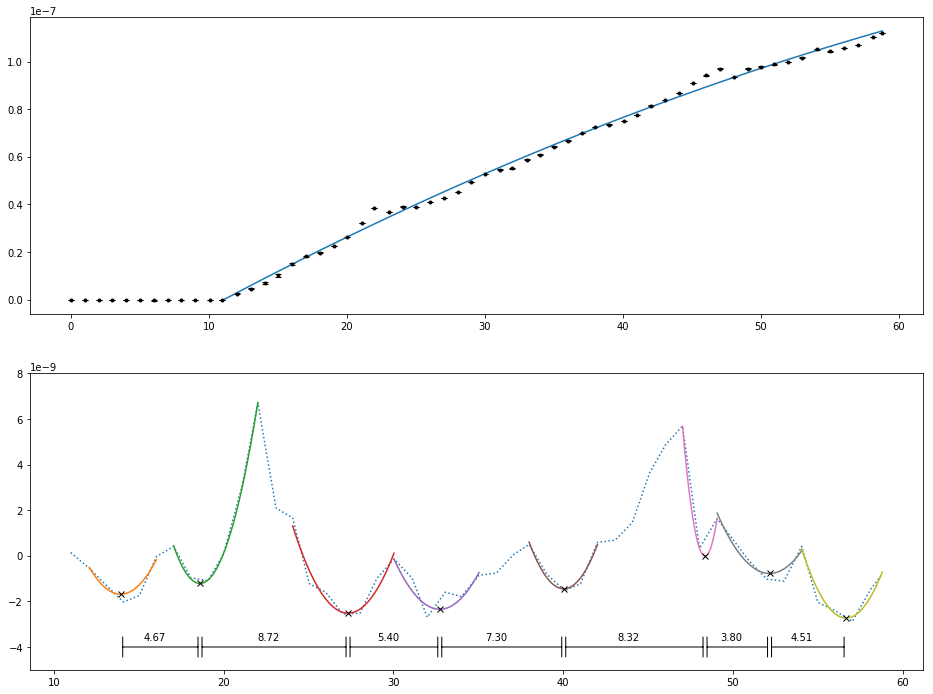

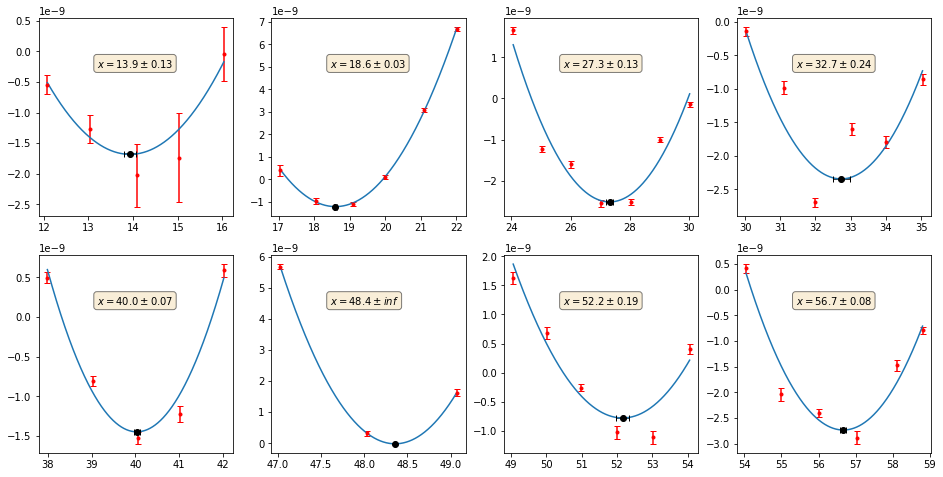

In [5]:
hg_exc = np.loadtxt("data/exc.tsv")
hg_exc[:, 1] = -hg_exc[:, 1]  # flip current
fig, axs = plt.subplots(nrows=2, figsize=(16,12))

axs[0].errorbar(hg_exc[:,0], hg_exc[:,1], yerr=hg_exc[:,2], fmt="k.");

# fit to slope
n_lin = 49
x_exc_fit = hg_exc[-n_lin:, 0]
y_exc_actual = hg_exc[-n_lin:, 1]
yerr_exc = hg_exc[-n_lin:, 2]
exc_fit_coeffs, _ = opt.curve_fit(
    poly1, x_exc_fit, y_exc_actual, sigma=yerr_exc, p0=poly1_p0
)
y_exc_fit = poly1(x_exc_fit, *exc_fit_coeffs)
axs[0].plot(x_exc_fit, y_exc_fit, label="fit");

# remove upward trend
y_exc_diff = y_exc_actual-y_exc_fit
# axs[1].errorbar(x_exc_fit, y_exc_diff, yerr=yerr_exc, fmt="--");
axs[1].plot(x_exc_fit, y_exc_diff, ":");

# get peaks as prelim for fit
i_peaks, _ = signal.find_peaks(-y_exc_diff)
i_peaks = np.delete(i_peaks, 3)  # remove weird peak
# axs[1].plot(loc_peaks, y_exc_diff[i_peaks], "*");

# fit around each peak, get peak centers, and get voltage diffs
fig, axs2 = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axs2 = axs2.flatten()
fit_ranges = [
    (2.5, 2.5), (2.5, 3.5), (3.5, 3.5),
#     (2.5, 4.5), (2.5, 2.5), (2.5, 2.5),
    (4.5, 1.5), (2.5, 2.5),
    (1.5, 1.5), (4.5, 1.5), (3.5, 2.5),
]
centers = []
for ax, i_peak, fit_range in zip(axs2, i_peaks, fit_ranges):
    peak_loc = x_exc_fit[i_peak]
    i = np.logical_and(
        x_exc_fit <= peak_loc+fit_range[1],
        x_exc_fit >= peak_loc-fit_range[0],
    )
    x, y, yerr = x_exc_fit[i], y_exc_diff[i], yerr_exc[i]
    ax.errorbar(x, y, yerr=yerr, fmt="r.", label="actual")
    
    peak_coeffs, peak_pcov = opt.curve_fit(
        poly2, x, y, sigma=yerr,
        p0=[-1, peak_loc, y_exc_diff[i_peak]],
    )
    peak_perr = np.sqrt(np.diag(peak_pcov))
    x_disp = np.arange(x[0], x[-1], 0.001)
    y_disp = poly2(x_disp, *peak_coeffs)
    ax.plot(x_disp, y_disp)
    axs[1].plot(x_disp, y_disp)
    
#     a, b, _ = peak_coeffs
#     x_center = -b/(2*a)
#     y_center = poly2(x_center, *peak_coeffs)
    _, x_center, y_center = peak_coeffs
    centers.append([x_center, y_center])
    
    ax.errorbar(x_center, y_center, xerr=peak_perr[1], fmt="ko")
    legend_labels = ["x"]

    text_str = "\n".join(
        f"${label} = {value:.1f} \pm {sigma:.2f}$"
        for label, value, sigma in zip(legend_labels, [x_center], [peak_perr[1]])
    )

    ax.text(
        0.3, 0.8, text_str, transform=ax.transAxes,
        verticalalignment="top", bbox=BOX_PROPS,
    )
    
centers = np.array(centers)
diffs = np.diff(centers[:,0])
axs[1].plot(centers[:,0], centers[:,1], "xk")

# annotate distances
axs[1].set_ylim(-5e-9, 8e-9)
y_ruler = -4e-9
for i, diff in enumerate(diffs):
    c_c, n_c = centers[i, 0], centers[i+1, 0]
    m_c = np.mean([c_c, n_c])
    axs[1].annotate(
        "", xy=(c_c, y_ruler), xytext=(n_c, y_ruler),
        arrowprops=dict(arrowstyle="|-|"),
    )
    axs[1].annotate(f"{diff:.2f}", xy=(m_c-1, y_ruler+0.3e-9))
    

array([[[1.48818589e+01, 1.01254736e+00],
        [1.86161062e+01, 2.49466750e-02],
        [2.85480957e+01, 2.90798984e+00],
        [           nan,            nan],
        [4.03173257e+01, 1.60456975e-01],
        [           nan,            nan],
        [5.23311135e+01, 5.66493708e-02],
        [5.64271449e+01, 3.08789144e-01]],

       [[1.41967292e+01, 2.28635451e-02],
        [1.86534290e+01, 5.48102494e-03],
        [2.73676056e+01, 4.61906241e-02],
        [3.12650653e+01, 1.35892242e+01],
        [4.01571924e+01, 4.22903105e-02],
        [4.90370386e+01, 5.22519008e-01],
        [5.34686996e+01, 5.06154031e-01],
        [5.66959439e+01, 3.92522401e-01]],

       [[1.39291193e+01, 1.30735860e-01],
        [1.86194210e+01, 2.12735520e-02],
        [2.70810877e+01, 1.93788975e-01],
        [3.74332844e+01, 4.78150745e+00],
        [4.00320436e+01, 7.23930742e-02],
        [5.06201084e+01, 6.62472016e+00],
        [5.21093498e+01, 3.70792318e+00],
        [5.64379457e+01, 2.514

,0,1
0,14.335902,0.388716
1,18.629652,0.017234
2,27.665596,1.049323
3,34.349175,9.185366
4,40.168854,0.091713
5,49.828574,3.573620
6,52.636388,1.423576
7,56.520345,0.317595


,0
0,0.401211
1,0.016867
2,0.634889
3,3.084110
4,0.116757
5,0.791535
6,0.595456
7,0.124246


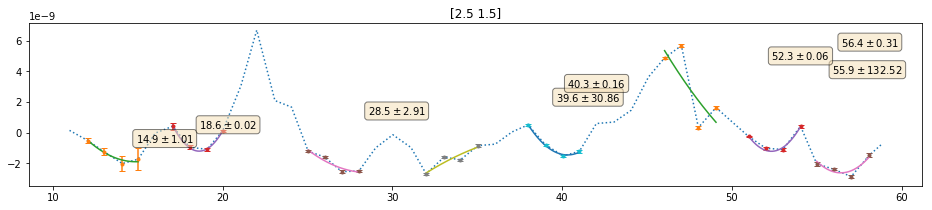

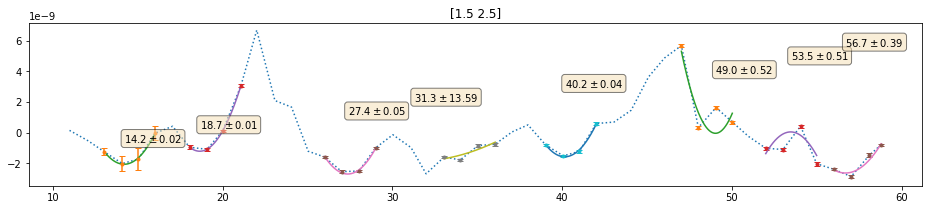

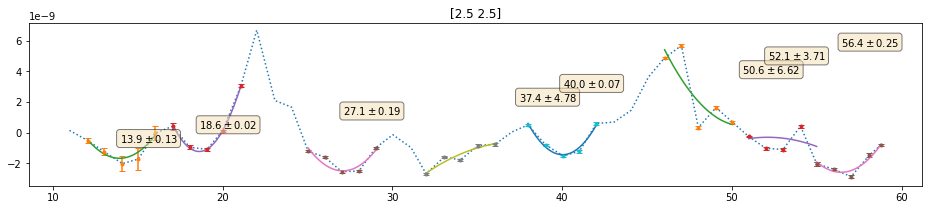

In [6]:
def fit_single(i_peak, fit_range, ax=None):
    """each row is a parameter and its variance"""
    peak_loc = x_exc_fit[i_peak]
    i = np.logical_and(
        x_exc_fit <= peak_loc+fit_range[1],
        x_exc_fit >= peak_loc-fit_range[0],
    )
    x, y, yerr = x_exc_fit[i], y_exc_diff[i], yerr_exc[i]
    peak_coeffs, peak_pcov = opt.curve_fit(
        poly2, x, y, sigma=yerr,
        p0=[-1, peak_loc, y_exc_diff[i_peak]],
    )
#     peak_coeffs, peak_pcov = opt.curve_fit(
#         poly1, x, y, sigma=yerr, p0=poly1_p0,
#     )
    values = np.vstack([peak_coeffs, np.diag(peak_pcov)]).T
    
    if ax:
        ax.errorbar(x, y, yerr=yerr, fmt=".")
        x_disp = np.arange(x[0], x[-1], 0.001)
        y_disp = poly2(x_disp, *peak_coeffs)
        ax.plot(x_disp, y_disp)
    
    return values

def get_centers(i_peaks, fit_range, disp=False):
#     fig, axs2 = plt.subplots(nrows=1, ncols=8, figsize=(16, 4))
#     axs2 = axs2.flatten()
#     print(f"on range {fit_range}")

    fig, ax = plt.subplots(figsize=(16, 3))
    ax.plot(x_exc_fit, y_exc_diff, ":");
    ax.set_title(str(fit_range))
    
    centers = []
#     for ax, i_peak in zip(axs2, i_peaks):
    for i, i_peak in enumerate(i_peaks):
        fit_res = fit_single(i_peak, fit_range, ax)
        
#         x_center = -fit_res[1, 0]/(2*fit_res[0, 0])
#         x_err = x_center/2*np.sqrt(fit_res[0, 1]/(fit_res[0, 0]**2) + fit_res[1, 1]/(fit_res[1, 0])**2)
        
        _, x_center, y_center = fit_res[:, 0]
        x_err = np.sqrt(fit_res[1,1])
        centers.append([x_center, x_err])
        
        ax.text(
            x_center, i*0.9e-9, f"${x_center:.1f} \pm {x_err:.2f}$",
            verticalalignment="top", bbox=BOX_PROPS,
        )

    return np.array(centers)


ranges = np.array([
    [2, 1],
    [1, 2],
#     [1, 3],
#     [3, 1],
    [2, 2],
])
ranges = ranges + 0.5
import pandas as pd

ccc = np.array([get_centers(i_peaks, r) for r in ranges])
ccc[0, 5, :] = np.nan  # has an error of 150; fit is clearly wrong
ccc[0, 3, :] = np.nan  # has an error of 30; fit is clearly wrong

means = np.nanmean(ccc, axis=0)
stds = np.nanstd(ccc, axis=0)[:, 0]

display(ccc)
display(pd.DataFrame(means), pd.DataFrame(stds))

peaks and diffs


,0,1
0,14.335902,0.558632
1,18.629652,0.024114
2,27.665596,1.226444
3,34.349175,9.689307
4,40.168854,0.148471
5,49.828574,3.660230
6,52.636388,1.543093
7,56.520345,0.341033


,0,1,2
0,2.0,4.293750,0.559152
1,3.0,9.035944,1.226681
2,4.0,6.683579,9.766619
3,5.0,5.819679,9.690445
4,6.0,9.659720,3.663240
5,7.0,2.807814,3.972206
6,8.0,3.883957,1.580329


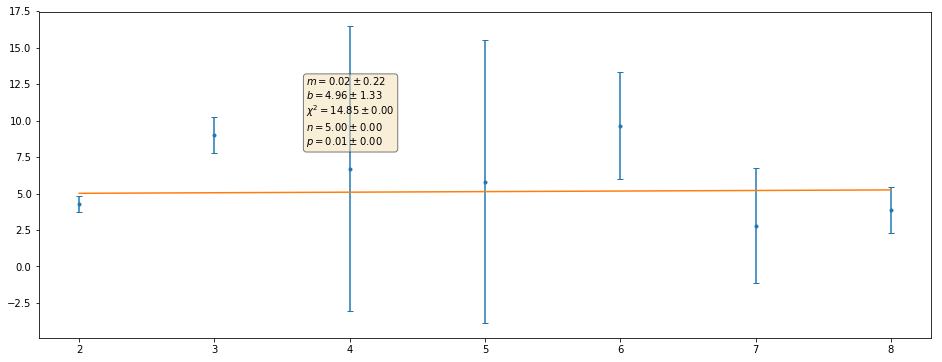

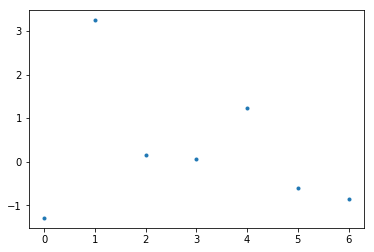

In [7]:
def linear2(x, *p):
    m, b = p
    return m*(2*x-1)+b

v_peaks = np.vstack([
    means[:,0], np.sqrt(np.square(stds)+np.square(means[:,1]))
]).T
v_diffs = np.vstack([
    np.arange(v_peaks.shape[0]-1)+2,
    np.diff(v_peaks[:,0]), 
    np.sqrt(np.convolve(np.array([1,1]), np.square(v_peaks[:, 1]), "valid")),
]).T

print("peaks and diffs")
display(pd.DataFrame(v_peaks), pd.DataFrame(v_diffs))

fig, ax = plt.subplots(figsize=(16,6))
ax.errorbar(v_diffs[:,0], v_diffs[:, 1], yerr=v_diffs[:, 2], fmt=".")

diff_coeffs, diff_vars = opt.curve_fit(
    linear2, v_diffs[:,0], v_diffs[:, 1], sigma=v_diffs[:, 2], p0=[1,0]
)
diff_errs = np.sqrt(np.diag(diff_vars))
y_diff_fit = linear2(v_diffs[:, 0], *diff_coeffs)
ax.plot(v_diffs[:, 0], y_diff_fit)

c2, ndof, p, ratios = chi_squared(v_diffs[:,1], y_diff_fit, v_diffs[:,2], n_params=2)
plt.figure()
plt.plot(ratios, ".")

legend_labels = ["m", "b", "\chi^2", "n", "p"]
text_str = "\n".join(
    f"${label} = {value:.2f} \pm {sigma:.2f}$"
    for label, value, sigma in zip(
        legend_labels,
        np.hstack([diff_coeffs, c2, ndof, p]),
        np.hstack([diff_errs, 0, 0, 0]),
    )
)
ax.text(
    0.3, 0.8, text_str, transform=ax.transAxes,
    verticalalignment="top", bbox=BOX_PROPS,
);

In [8]:
# MINIMA FOR CONTACT
_, b = diff_coeffs
_, s_b = diff_errs
# look at the gaps; we couldnt derive peaks due low signal to noise ratio
indices_coeffs = np.array([0,1,3,4,6,8,9,10])+1.5
# poop = v_peaks[:, 0] - (np.arange(v_peaks.shape[0])+1.5)*b
v_contacts = v_peaks[:, 0] - indices_coeffs*b
s_v_contacts = np.sqrt(np.square(v_peaks[:, 1])+np.square(indices_coeffs*s_b))
# display(v_peaks[:,1])
display(v_contacts[0], s_v_contacts[0])

6.90140017508193

2.0729978333316588

In [9]:
(ion[0] - v_contacts[0] - 1.499)
np.sqrt(ion[1]**2 + s_v_contacts[0]**2)

2.516302474764834